# Plot IV and FI curves

Copyright (c) 2025 Open Brain Institute

Authors: Ilkan Kilic

last modified: 01.2025

## Summary
This notebook demonstrates how to compute and plot the IV (current-voltage) and FI (frequency-current) curves for single cell model using BlueCelluLab. These analyses provide insights into the neuron’s electrical properties, such as its input resistance, firing threshold, and response to varying levels of stimulation. The notebook also explains how to set different injection and recording locations to study various neuron behaviors, like dendritic integration, backpropagation, and somatic excitability, through IV and FI curve analyses.

In [ ]:
from pathlib import Path
import zipfile
import json

from bluecellulab.analysis.analysis import compute_plot_iv_curve, compute_plot_fi_curve
from bluecellulab.cell import Cell
from bluecellulab.circuit.circuit_access import EmodelProperties
from bluecellulab.tools import calculate_rheobase
from bluecellulab.simulation.neuron_globals import NeuronGlobals

--No graphics will be displayed.


First, we will open the cadpyr_emodel.zip file, extracts its content and retrieve the data

In [2]:
emodel_folder = Path("cadpyr_emodel")
with zipfile.ZipFile("cadpyr_emodel.zip", mode="r") as archive:
    archive.extractall("./")
with open(emodel_folder / "metadata.json") as f:
    metadata = json.load(f)
hoc_file = emodel_folder / metadata["hoc_file"]
morph_file = emodel_folder / metadata["morph_file"]
mechanisms_folder = emodel_folder / metadata["mechanisms_folder"]
threshold_current = metadata["threshold_current"]
holding_current = metadata["holding_current"]
emodel_name = metadata["emodel_name"]

If the holding current and the threshold current are not available, we will use default values of 0 for both for now, and compute the threshold current later on.

In [3]:
if holding_current is None:
    print("No holding current provided, will set it to 0.")
    holding_current = 0
compute_threshold = False
if threshold_current is None:
    compute_threshold = True
    threshold_current = 0
emodel_properties = EmodelProperties(
    threshold_current=threshold_current,
    holding_current=holding_current,
)

This cell sets global neuronal parameters for the NEURON simulation. The temperature affects ion channel kinetics, and the initial membrane potential should match the model’s resting voltage. Adjust these values based on your HOC model.

In [4]:
neuron_globals = NeuronGlobals.get_instance()
neuron_globals.temperature = 34.0
neuron_globals.v_init = -80.0

Next, you will need to compile the mechanisms located in the emodel folder, which was created after extracting the zip file. Run the following cell to complete the compilation.

In [ ]:
!nrnivmodl emodel/mechanisms

We can now create our cell using BlueCelluLab:

In [6]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

Now that we have a cell, we can compute its threshold current if it was not provided in the metadata. First, we compute its RMP (resting membrane potential) and Rin (internal resistance) to get a maximum bound for threshold current, and use a bisection search algorithm. BlueCelluLab can handle all of that:

In [8]:
if compute_threshold:
    print("No threshold current provided, will attempt to compute it. This will take a few seconds...")
    emodel_properties.threshold_current = calculate_rheobase(cell)

In [9]:
print(f"holding current is {emodel_properties.holding_current} nA.")
print(f"threshold current is {emodel_properties.threshold_current} nA.")

holding current is -0.08750000000000001 nA.
threshold current is 0.1624028733588378 nA.


To compute and plot the IV and FI curves, we can simply call the two functions below, passing only the cell as an argument. This runs the simulation with default parameters. 

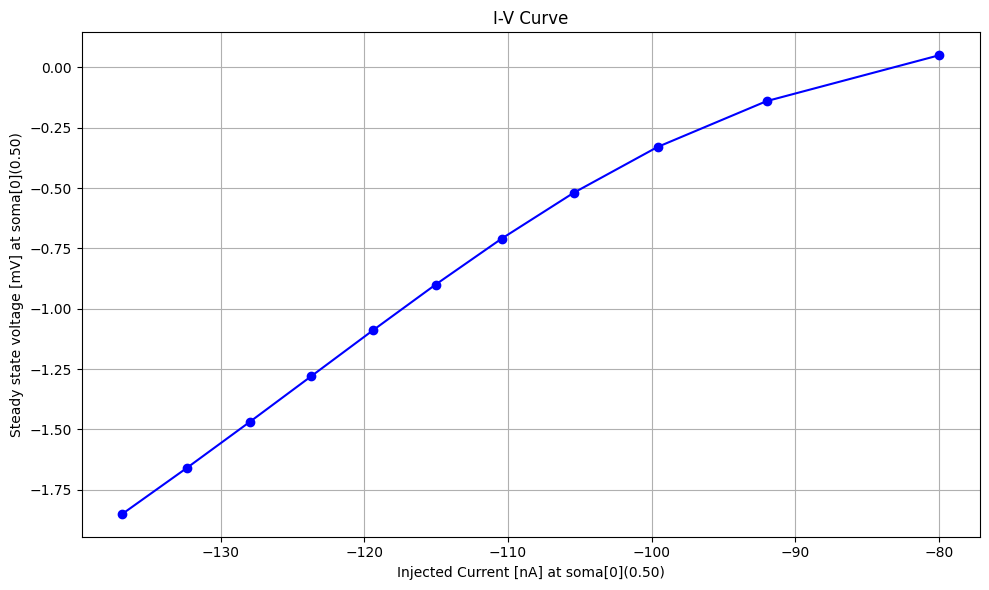

(array([-1.84952229, -1.65952229, -1.46952229, -1.27952229, -1.08952229,
        -0.89952229, -0.70952229, -0.51952229, -0.32952229, -0.13952229,
         0.05047771]),
 array([[-136.84187943],
        [-132.36293835],
        [-127.99943145],
        [-123.70378006],
        [-119.41258239],
        [-115.03808158],
        [-110.45006696],
        [-105.43516441],
        [ -99.59189954],
        [ -91.99916204],
        [ -79.98909745]]))

In [10]:
_, _ = compute_plot_iv_curve(cell)

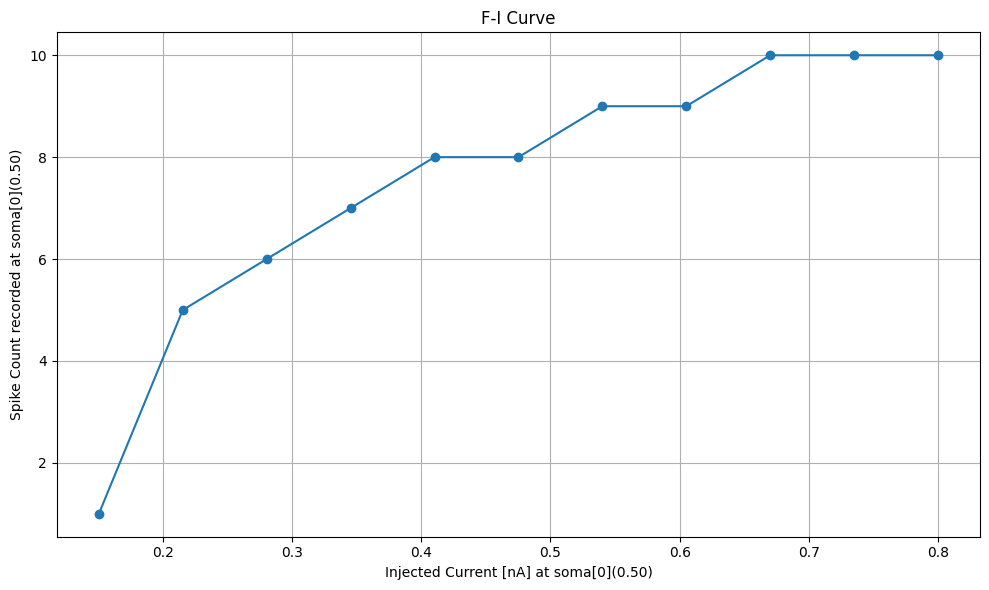

(array([0.15047771, 0.21542994, 0.28038217, 0.3453344 , 0.41028663,
        0.47523886, 0.54019108, 0.60514331, 0.67009554, 0.73504777,
        0.8       ]),
 array([ 1,  5,  6,  7,  8,  8,  9,  9, 10, 10, 10]))

In [11]:
_, _ = compute_plot_fi_curve(cell)

By default, current injection and voltage recording occur at the soma. However, we can customize the simulation by adjusting parameters such as injection and recording locations, stimulus duration, voltage threshold, and more.

In [12]:
stim_start=100.0
duration=500.0
post_delay=100.0
threshold_voltage=-30
nb_bins = 6

## Use cases

The following cells present different use cases for computing and plotting IV and FI curves. Each case explores a unique injection and recording configuration to highlight key aspects of neuronal behavior, such as dendritic integration, backpropagation and axonal influence. These variations help demonstrate how different stimulation locations affect the cell's response.

In [13]:
def plot_iv_fi(injecting_section, injecting_segment, recording_section, recording_segment):
    _,_ = compute_plot_iv_curve(
        cell,
        injecting_section=injecting_section,
        injecting_segment=injecting_segment,
        recording_section=recording_section,
        recording_segment=recording_segment,
        stim_start=stim_start,
        duration=duration,
        post_delay=post_delay,
        threshold_voltage=threshold_voltage,
        nb_bins=nb_bins
    )
    _,_ = compute_plot_fi_curve(
        cell,
        injecting_section=injecting_section,
        injecting_segment=injecting_segment,
        recording_section=recording_section,
        recording_segment=recording_segment,
        stim_start=stim_start,
        duration=duration,
        post_delay=post_delay,
        nb_bins=nb_bins
    )

### Dendritic Integration and Attenuation

Injecting current at a dendrite and recording at the soma.
This setup shows how dendritic stimulation propagates to the soma, 
highlighting attenuation and possible active dendritic mechanisms.

In [19]:
injecting_section = "dend[50]"
injecting_segment = 0.5
recording_section = "soma[0]"
recording_segment = 0.5

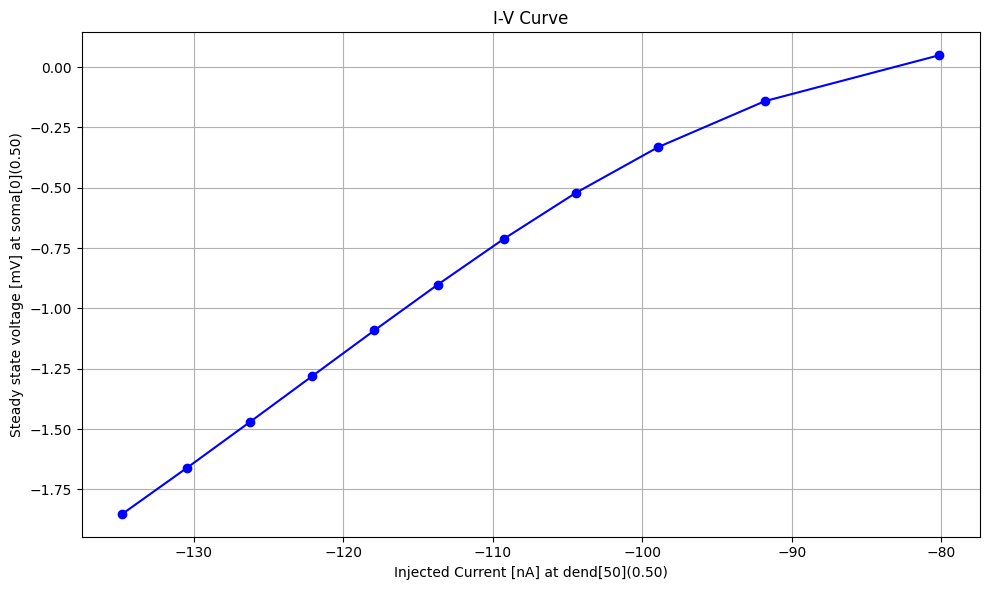

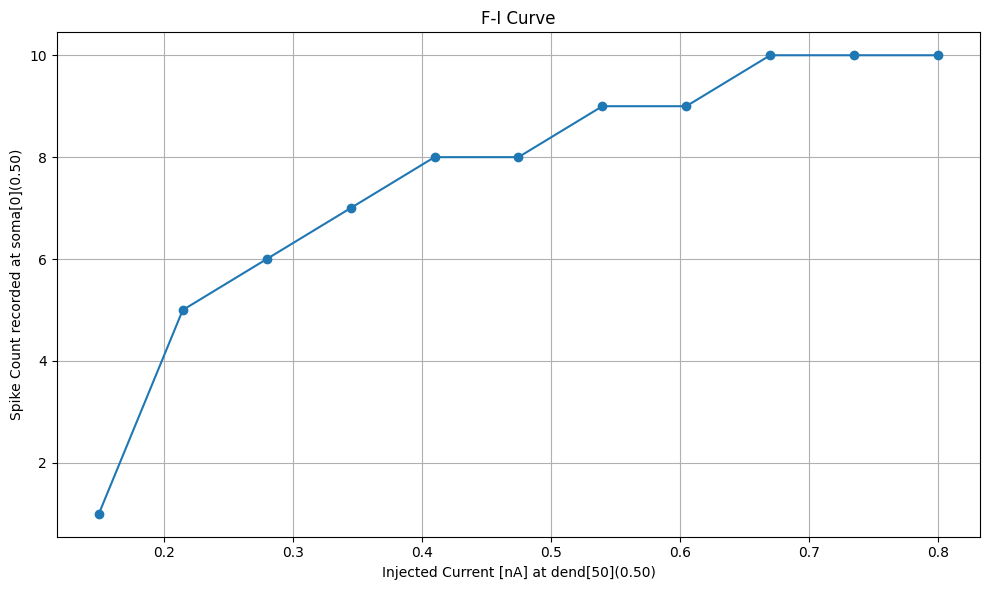

In [20]:
plot_iv_fi(injecting_section, injecting_segment, recording_section, recording_segment)

### Exploring Backpropagation from the Axon

Injecting current at the axon and recording at the soma.
This setup helps investigate whether axonal stimulation can backpropagate 
to the soma and affect firing properties.


In [24]:
injecting_section = "axon[0]"
injecting_segment = 0.5
recording_section = "soma[0]"
recording_segment = 0.5

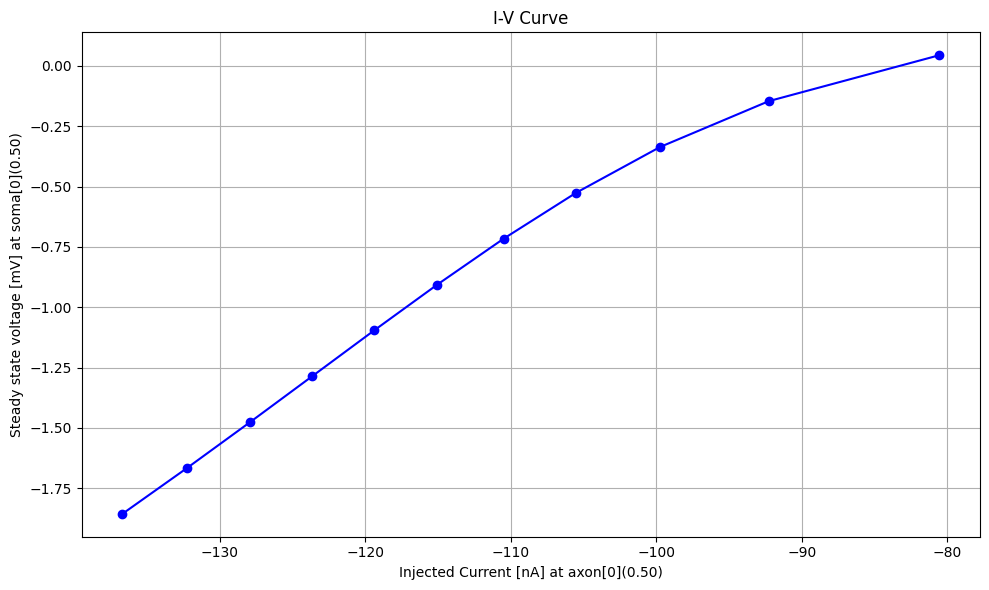

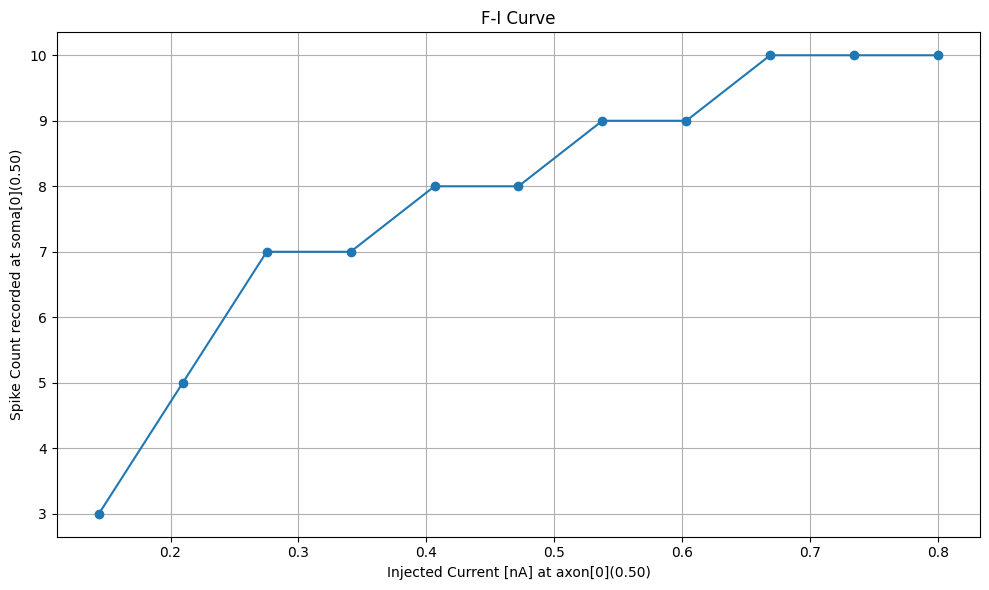

In [25]:
plot_iv_fi(injecting_section, injecting_segment, recording_section, recording_segment)

### Examining Local Dendritic Computations

Injecting and recording at different dendritic locations.
This setup isolates dendritic computations, showing how input at one dendrite 
propagates (or fails to propagate) to another part of the dendritic tree.

In [26]:
injecting_section = "dend[25]"
injecting_segment = 0.5
recording_section = "dend[50]"
recording_segment = 0.5

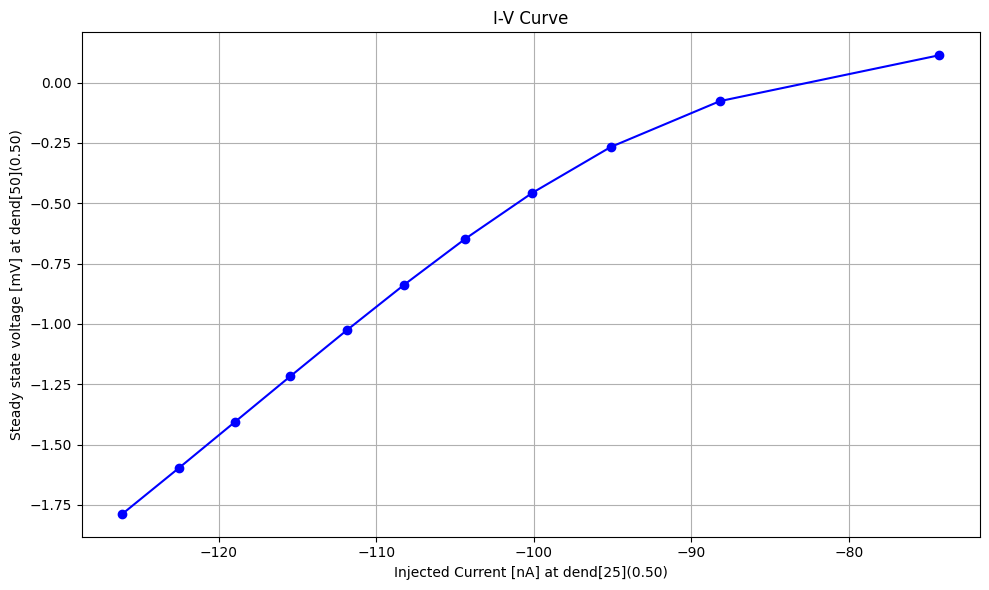

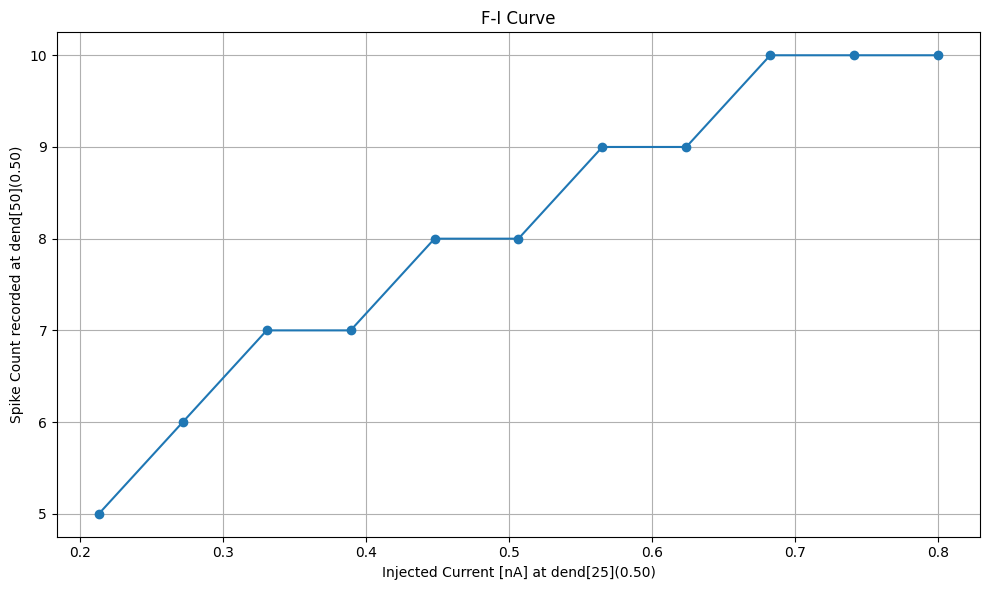

In [27]:
plot_iv_fi(injecting_section, injecting_segment, recording_section, recording_segment)

### Testing Whether Somatic Stimulation Reaches the Axon

Injecting current at the soma and recording at the axon.
This setup helps determine if somatic stimulation effectively depolarizes the axon 
enough to trigger an action potential.

In [28]:
injecting_section = "soma[0]"
injecting_segment = 0.5
recording_section = "axon[0]"
recording_segment = 0.5

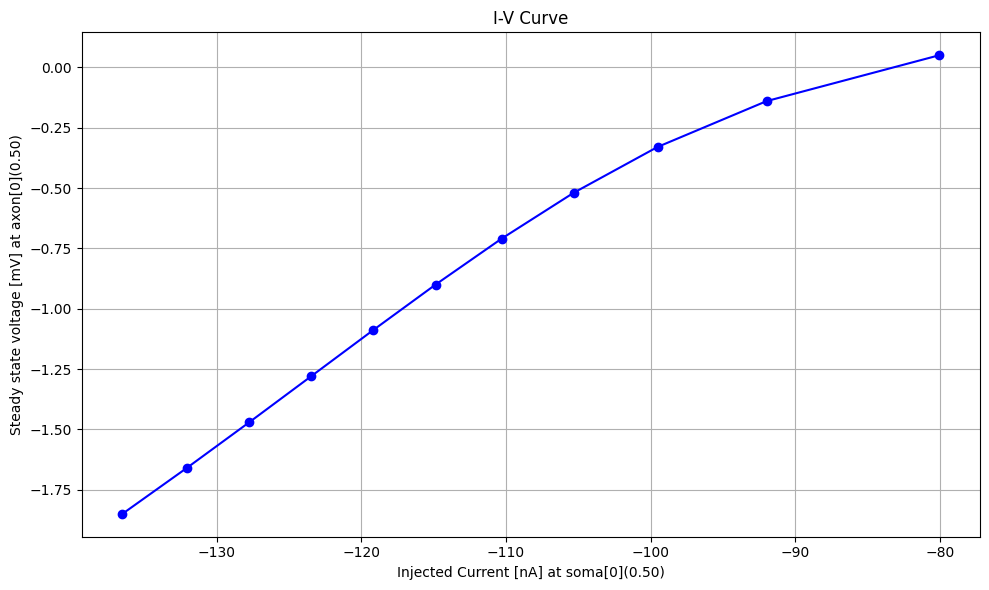

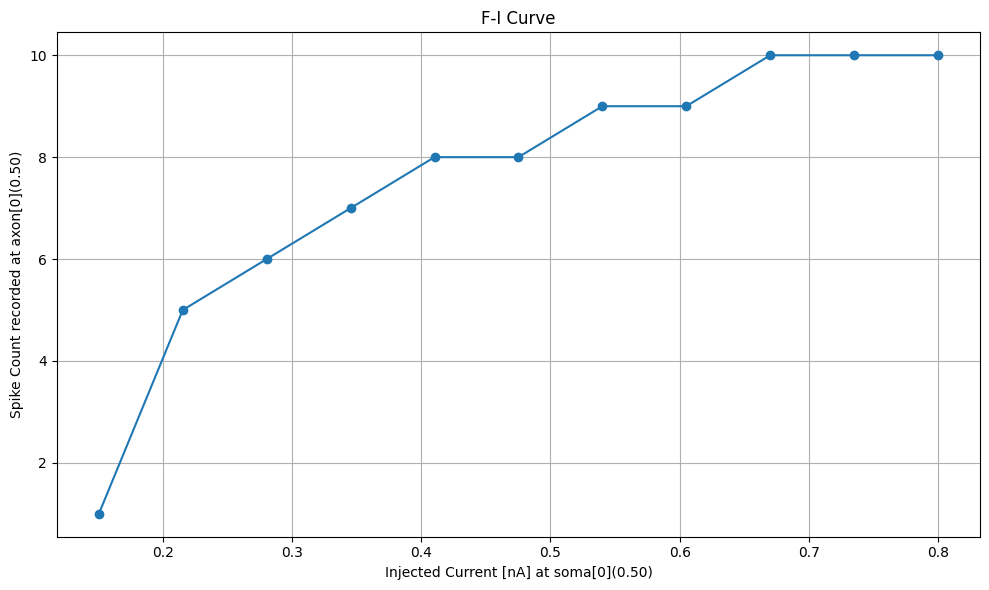

In [29]:
plot_iv_fi(injecting_section, injecting_segment, recording_section, recording_segment)